# Weather Forecasting
            1. Slicing dataset 
            2. Data Pre-processing
            3. Visualize the Time Series Data
            4. Plot the correlation and AutoCorrelation Charts
            4. Consruct the ARIMA model and SARIMA based on the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima





In [3]:
df=pd.read_csv('Denawaka_project.csv')
df.head()




,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,233.6,22.1,32.1,NaN,NaN
1,2010,February,111.9,22.6,33.9,NaN,NaN
2,2010,March,157.5,23.1,35.2,NaN,NaN
3,2010,April,438.3,23.7,33.5,NaN,NaN
4,2010,May,658.5,24.0,31.8,NaN,NaN


In [4]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)




In [5]:
#Creating time column
df['Time'] = pd.to_datetime(df['Time'])

In [6]:
df.head()


,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,233.6,22.1,32.1,NaN,NaN,2010-01-01
1,2010,February,111.9,22.6,33.9,NaN,NaN,2010-02-01
2,2010,March,157.5,23.1,35.2,NaN,NaN,2010-03-01
3,2010,April,438.3,23.7,33.5,NaN,NaN,2010-04-01
4,2010,May,658.5,24.0,31.8,NaN,NaN,2010-05-01


In [7]:
rainfall=df[["Time","Rainfall"]]
rainfall.head()



,Time,Rainfall
0,2010-01-01,233.6
1,2010-02-01,111.9
2,2010-03-01,157.5
3,2010-04-01,438.3
4,2010-05-01,658.5


Slicing dataset into different time series

#                                        Forecasting rainfall

In [8]:
#Checking for missing values
rainfall.isna().sum()


Time        0
Rainfall    0
dtype: int64

In [9]:
rainfall.set_index('Time',inplace=True)

In [10]:
rainfall=rainfall.resample('MS').first()

In [11]:
#filling missing values
rain=rainfall.fillna(method='bfill')
rain.head()



,Rainfall
Time,
2010-01-01,233.6
2010-02-01,111.9
2010-03-01,157.5
2010-04-01,438.3
2010-05-01,658.5


In [12]:
#Checking for missing values
rain.isna().sum()

Rainfall    0
dtype: int64

#  Visualize the Data

<AxesSubplot:xlabel='Time'>

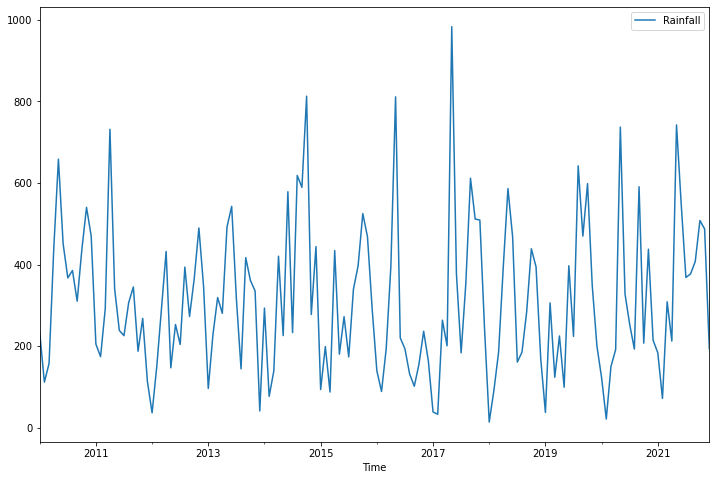

In [13]:
rain.plot(figsize=(12,8))


No significant trend. But it can be seen that there is some evidence for seasonality. 

# Testing For Stationarity

In [14]:
### ADF Test
test_result=adfuller(rain['Rainfall'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(rainfall):
    result=adfuller(rainfall)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(rain['Rainfall'])


ADF Test Statistic : -3.89004730480056
p-value : 0.002109326728912184
#Lags Used : 13
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [15]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(rain['Rainfall'])


KPSS Statistic: 0.06801147225081985
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [16]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(rain['Rainfall'])
print(pp.summary().as_text())


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -8.526
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# ACF and PACF plots

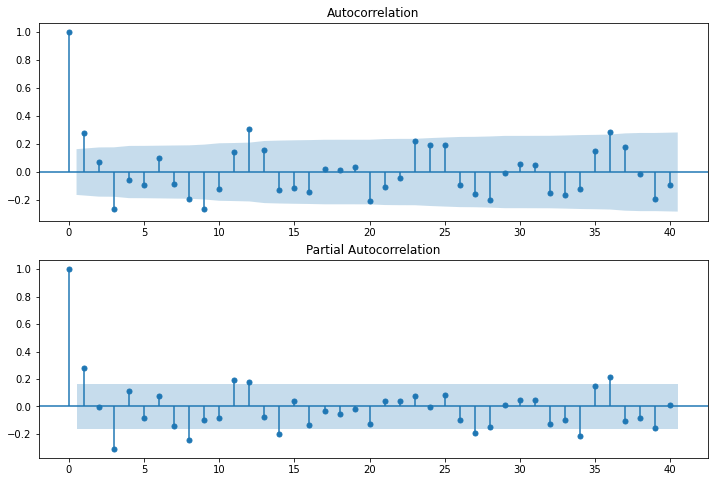

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(rain['Rainfall'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(rain['Rainfall'],lags=40,ax=ax2)


Fitting ARMA model

In [18]:
# For non-seasonal data
#According to PACF and ACF plots, p=3 d=0 and q=3 can be considered.
arima_model=auto_arima(rain['Rainfall'].astype(float),start_p=0,start_q=0,max_p=3,max_q=3,start_P=0,start_Q=0,max_P=3,max_Q=3,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=False,random_state=20,n_fits=70,maxiter=70,alpha=0.05)


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1915.059, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1904.493, Time=0.20 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1905.007, Time=0.37 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=1902.444, Time=0.86 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1901.474, Time=0.33 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1906.297, Time=0.33 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1906.958, Time=0.82 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=1880.571, Time=3.10 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1901.028, Time=0.55 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1905.162, Time=0.77 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=1899.936, Time=3.75 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=1893.522, Time=1.41 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=2.90 sec
 ARIMA(0,0

Fitting SARIMA model

In [20]:
model=sm.tsa.statespace.SARIMAX(rain['Rainfall'].astype('float'),order=(2,0,1),seasonal_order=(1,0,1,12))
results=model.fit()
results.summary()


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Rainfall   No. Observations:                  144
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -942.266
Date:                            Tue, 26 Apr 2022   AIC                           1896.531
Time:                                    00:04:21   BIC                           1914.350
Sample:                                01-01-2010   HQIC                          1903.772
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1309      0.132      8.543      0.000       0.871       1.390
ar.L2         -0.1321      0.139     -0.948      0.343      -0.405       0.141
ma.L1         -0.9910      0.102     -9.714      0.000      -1.191      -0.791
ar.S.L12       0.9954      0.058     17.156      0.000       0.882       1.109
ma.S.L12      -0.9412      0.358     -2.627      0.009      -1.643      -0.239
sigma2      3.274e+04   8569.979      3.821      0.000    1.59e+04    4.95e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                31.57
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.93
Prob(H) (two-sided):                  0.71   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Forecast rainfall using the model

In [21]:
beg_dt='2017-01-01'
end_dt='2021-12-01'

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Time'>

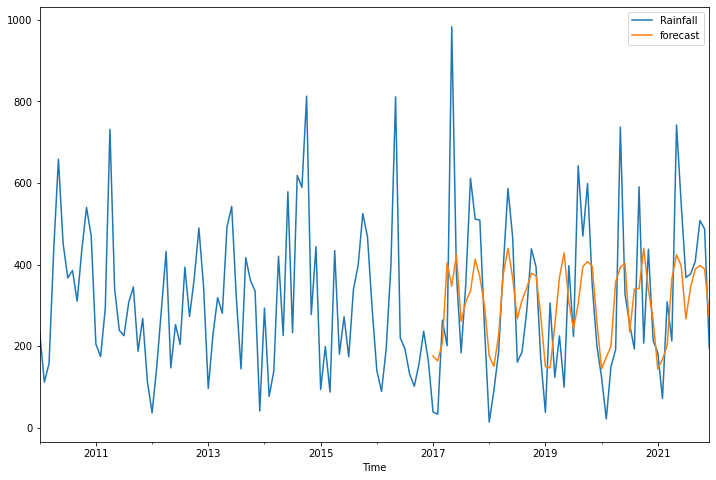

In [22]:
rain['forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=False)
rain[['Rainfall','forecast']].plot(figsize=(12,8))


In [23]:
rain.tail()

,Rainfall,forecast
Time,,
2021-08-01,377.1,344.359237
2021-09-01,407.7,388.952744
2021-10-01,508.0,397.808447
2021-11-01,487.4,388.953928
2021-12-01,193.7,270.818413


In [19]:
results.predict(start='2010-01-01',end='2025-01-01',dynamic=False)

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2010-01-01      0.000000
2010-02-01    181.182005
2010-03-01    134.617875
2010-04-01    152.259370
2010-05-01    257.714409
                 ...    
2024-09-01    318.939183
2024-10-01    321.711365
2024-11-01    321.134810
2024-12-01    312.993822
2025-01-01    314.770800
Freq: MS, Name: predicted_mean, Length: 181, dtype: float64